<a href="https://colab.research.google.com/github/rigidcode/Dataset/blob/main/Lecture_9_10_19_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Notebook, we will go step wise to create a mini end-to-end machine learning project. We will tackle the linear regression model. The example is from Chapter 2 of Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, by Aurélien Géron, published by O'Reilly Media.



#**Working with real data**
To work on a machine learning project, it is best to work with real world data. 

Popular open data repositories
   
*   [UC irvine ML Repository](http://archive.ics.uci.edu/ml/index.php)
*[Kaggle DataSets](https://www.kaggle.com/datasets)
*[Amazon AWS DataSets](https://registry.opendata.aws/)


For this lecture we will use the housing.csv dataset. This dataset is based on data from the 1990 California census. It is not exactly recent , but it has many qualities for learning, so we will pretend it is recent data. For teaching purposes I’ve added a categorical attribute and removed a few features.


##Step 1: Look at the Big Picture
Welcome to the Machine Learning Housing Corporation! Your first task is to use California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will call them “districts” for short.

Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

##Step 1.1: Frame the problem
* What exactly the business objective is? Knowing the objective is important because it will determine how you frame the problem, which algorithms you will select, which performance measure you will use to evaluate your model, and how much effort you will spend tweaking it.
* Say you boss says Your boss answers that your model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system, along with many other signals.3 This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.
* The next question to ask your boss is what the current solution looks like (if any). The current situation will often give you a reference for performance, as well as insights on how to solve the problem. 
* What can you do? : it is clearly a typical supervised learning task, since you are given labeled training examples (each instance comes with the expected output, i.e., the district’s median housing price). It is also a typical regression task, since you are asked to predict a value. More specifically, this is a multiple regression problem, since the system will use multiple features to make a prediction (it will use the district’s population, the median income, etc.). There is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning should do just fine.


##Step 1.2: Select a performance measure
* Typically for regression, it is the **root mean squared error**.  It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.
* Suppose that there are many outlier districts. In that case, you may consider using the **mean absolute error** (MAE, also called the average absolute deviation)

## Step 1.3: Check the assumption
It is good practice to list and verify the assumptions that have been made so far (by you or others); this can help you catch serious issues early on. For example, the district prices that your system outputs are going to be fed into a downstream Machine Learning system, and you assume that these prices are going to be used as such. But what if the downstream system converts the prices into categories (e.g., “cheap,” “medium,” or “expensive”) and then uses those categories instead of the prices themselves? In this case, getting the price perfectly right is not important at all; your system just needs to get the category right. If that’s so, then the problem should have been framed as a classification task, not a regression task. You don’t want to find this out after working on a regression system for months.

##Step 2 : Get the Data

In [10]:
from google.colab import files
uploaded = files.upload()

MessageError: ignored

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [9]:
housing = pd.read_csv("housing.csv",sep=',')
housing.head()

FileNotFoundError: ignored

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is fairly small by Machine Learning standards, but it’s perfect to get started. Notice that the total_bedrooms attribute has only 20,433 nonnull values, meaning that 207 districts are missing this feature. We will need to take care of this later.



In [ ]:
housing.describe()

longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

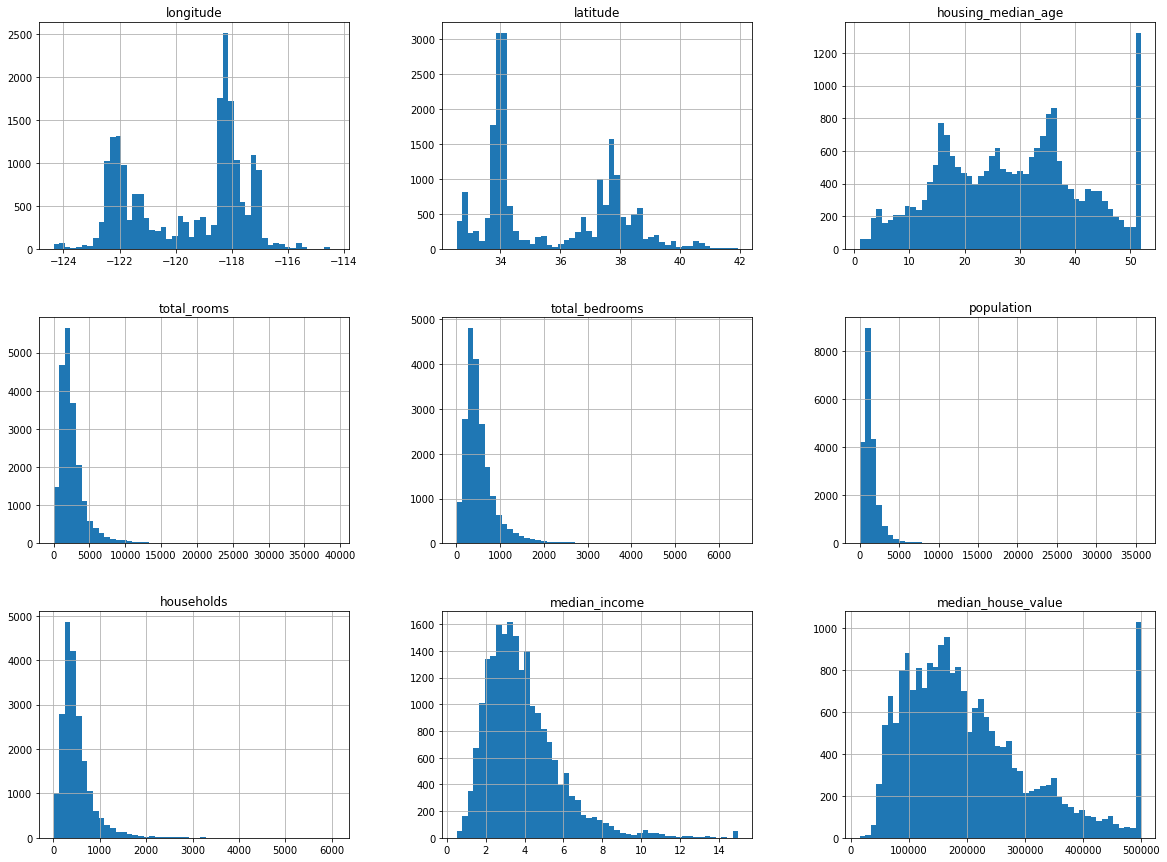

In [ ]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Step 2.1 Create Test Set
Creating a test set is theoretically simple: pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside.

In [ ]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(housing, 0.2)

In [ ]:
len(train_set)

16512

In [ ]:
len(test_set)

4128

Well, this works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid.

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
len(train_set)

16512

In [ ]:
len(test_set)

4128

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is 51.3% females and 48.7% males, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. If the people running the survey used purely random sampling, there would be about a 12% chance of sampling a skewed test set that was either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased.

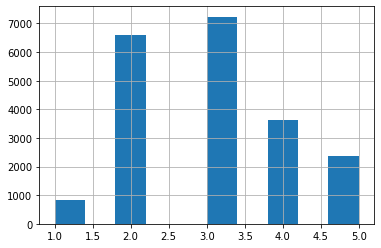

In [ ]:
housing['income_cat'] = pd.cut(
    x = housing['median_income'],
    bins = [0,1.5,3.0,4.5,6, np.inf],
    labels = [1,2,3,4,5]
)

plt.hist(housing.income_cat)
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


##Step 3: Visualize the Data to get Insights

First, keep test dataset aside.

In [ ]:
housing_explore = strat_train_set.copy()

Visualize Geographical Data

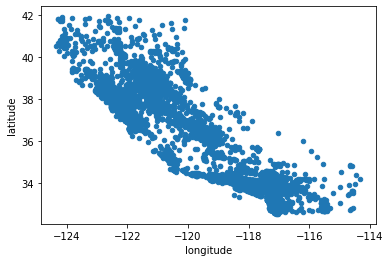

In [ ]:
housing_explore.plot(kind="scatter", x="longitude", y="latitude")

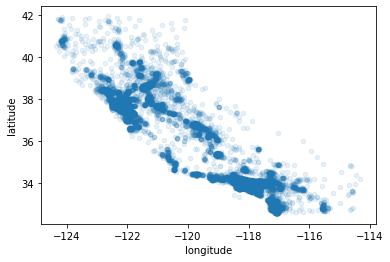

In [ ]:
housing_explore.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Look for correlations

In [ ]:
corr_matrix = housing_explore.corr()
corr_matrix

longitude  latitude  ...  median_income  median_house_value
longitude            1.000000 -0.924478  ...      -0.019583           -0.047432
latitude            -0.924478  1.000000  ...      -0.075205           -0.142724
housing_median_age  -0.105848  0.005766  ...      -0.111360            0.114110
total_rooms          0.048871 -0.039184  ...       0.200087            0.135097
total_bedrooms       0.076598 -0.072419  ...      -0.009740            0.047689
population           0.108030 -0.115222  ...       0.002380           -0.026920
households           0.063070 -0.077647  ...       0.010781            0.064506
median_income       -0.019583 -0.075205  ...       1.000000            0.687160
median_house_value  -0.047432 -0.142724  ...       0.687160            1.000000

[9 rows x 9 columns]

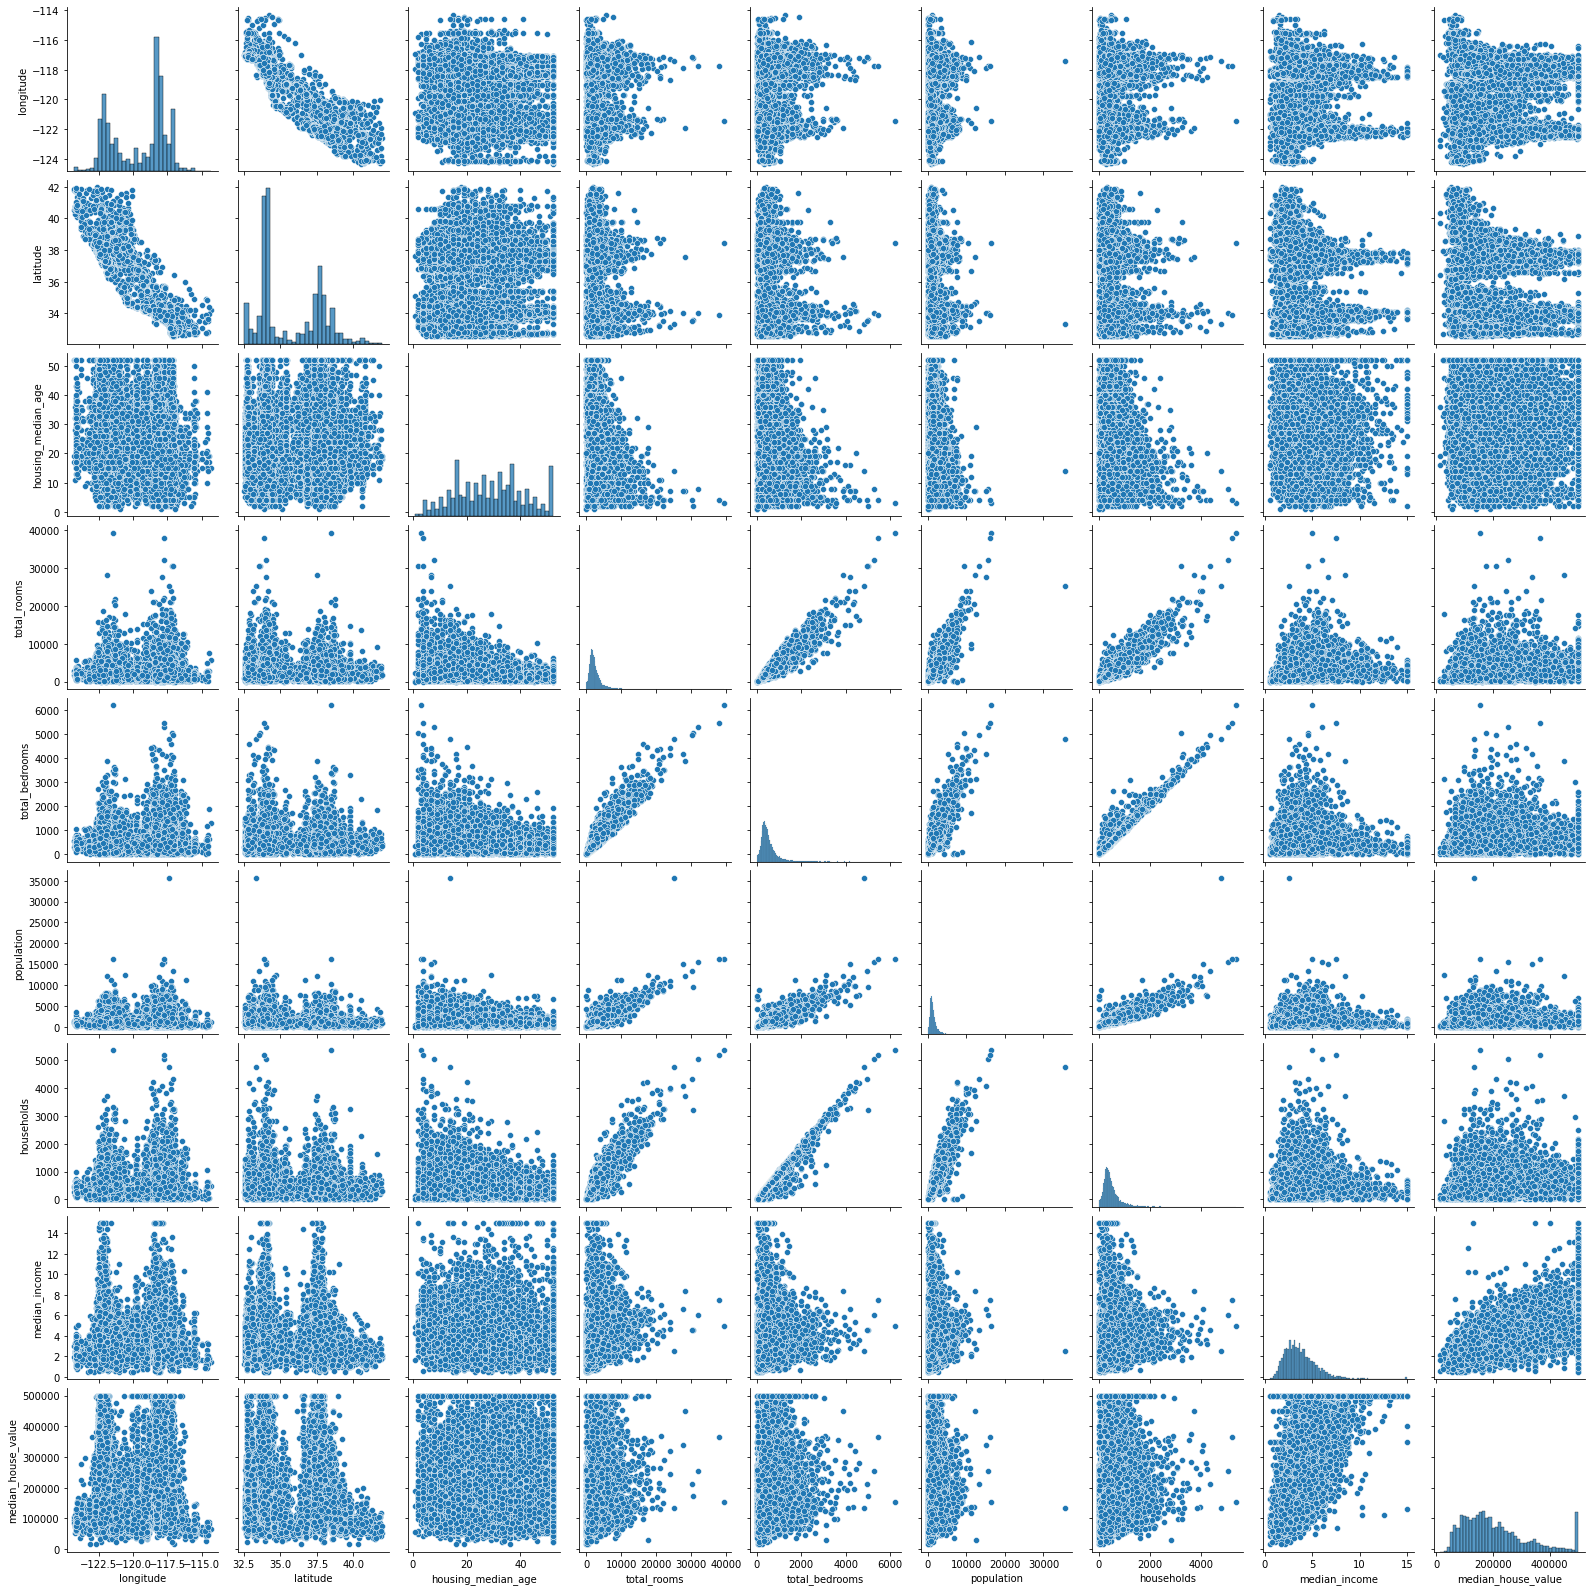

In [ ]:
import seaborn as sns
sns.pairplot(housing_explore)
plt.show()

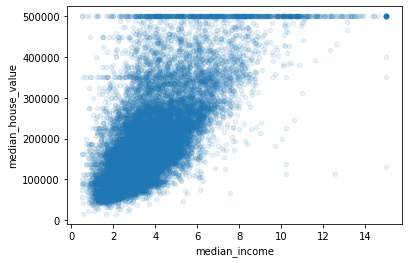

In [ ]:
housing_explore.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)


Explore Some New Attributes

In [ ]:
housing_explore["rooms_per_household"] = housing_explore["total_rooms"]/housing["households"]
housing_explore["bedrooms_per_room"] = housing_explore["total_bedrooms"]/housing["total_rooms"]
housing_explore["population_per_household"]=housing_explore["population"]/housing["households"]

In [ ]:
corr_matrix = housing_explore.corr()
corr_matrix

longitude  ...  population_per_household
longitude                  1.000000  ...                 -0.000410
latitude                  -0.924478  ...                  0.005420
housing_median_age        -0.105848  ...                  0.015031
total_rooms                0.048871  ...                 -0.024810
total_bedrooms             0.076598  ...                 -0.028370
population                 0.108030  ...                  0.076225
households                 0.063070  ...                 -0.027416
median_income             -0.019583  ...                  0.021822
median_house_value        -0.047432  ...                 -0.021985
rooms_per_household       -0.028345  ...                 -0.005314
bedrooms_per_room          0.095603  ...                  0.004279
population_per_household  -0.000410  ...                  1.000000

[12 rows x 12 columns]

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

Let’s also separate the predictors and the labels, since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set):

In [ ]:
housing_explore = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options: 
* Get rid of the corresponding districts.
* Get rid of the whole attribute.
* Set the values to some value (zero, the mean, the median, etc.).

You can accomplish these easily using DataFrame’s dropna(), drop(), and fillna() methods

Say you want to do the third option. Scikit-Learn provides a handy class to take care of missing values: **SimpleImputer**. Here is how to use it. First, you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, you need to create a copy of the data without the text attribute ocean_proximity.

In [ ]:
housing_num = housing_explore.drop("ocean_proximity", axis=1)

In [ ]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable. Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

Handling Text and Categorical Attributes

So far we have only dealt with numerical attributes, but now let’s look at text attributes. In this dataset, there is just one: the ocean_proximity attribute. Let’s look at its value for the first 10 instances.

In [ ]:
housing_cat = housing_explore[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

Convert these to numbers.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes. Scikit-Learn provides a OneHotEncoder class to convert categorical values into one-hot vectors:

![](https://i.imgur.com/mtimFxh.png)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**Recap on the data transformations we tried so far**
* Fix missing values in numeric columns/features (with median values)
* `OneHot` encode categorical variables `ocean_proximity`
* Add additional features: 
    * `rooms_per_household`
    * `bedrooms_per_room`
    * `population_per_household`
* Feature scaling (<span style="color:red">To Do</span>)

Custom Transformers:
lthough Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need to do is create a class and implement three methods: fit() (returning self), transform(), and fit_transform().

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_explore.values)

In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).



Feature Scaling:
One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required. 

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

**Min-max Scaling** : Values are shifted and rescaled so that they end up ranging from 0 to 1.

**Standardization** : First it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. 

Scikit-Learn provides a transformer called StandardScaler for standardization.

Transformation Pipelines

Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes.



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column. In version 0.20, Scikit-Learn introduced the ColumnTransformer for this purpose, and the good news is that it works great with pandas DataFrames. Let’s use it to apply all the transformations to the housing data:

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing_explore)

##Step 3: Selection and Training the model

#### 3.1 Training and Evaluating on the Training Set

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.64295459937

Let us look at a few predictions from the training set.

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))


Predictions: [404609.12062705 427586.7997437  382441.00975529 322063.03214456
 252628.71757537]
Labels: [286600, 340600, 196900, 46300, 254500]


/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


This is better than nothing, but clearly not a great score: most districts’ median_housing_values range between \$120,000 and \$265,000, so a typical prediction error of \$68,628 is not very satisfying. This is an example of a model underfitting the training data.

Maybe not a very good model. We need to try something more complex.

Let’s train a ***DecisionTreeRegressor***. This is a powerful model, capable of finding complex nonlinear relationships in the data

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Now that the model is trained, let’s evaluate it on the training set:

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse


0.0

##Better valuation Using Cross Validation

We can use Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
         print("Scores:", scores)
         print("Mean:", scores.mean())
         print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [68724.91418384 67320.76249296 69766.28357828 70124.16770431
 71570.07628237 74408.36412101 69307.51131944 70649.26668597
 77321.21818748 69406.63177088]
Mean: 70859.91963265387
Standard deviation: 2796.9948848369845


That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

Let’s try one last model now: the RandomForestRegressor. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further. We will skip most of the code since it is essentially the same as for the other models:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18626.45217719628

Wow, this is much better: Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. Before you dive much deeper into Random Forests, however, you should try out many other models from various categories of Machine Learning algorithms (e.g., several Support Vector Machines with different kernels, and possibly a neural network), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

##Fine Tune Your Model

###Grid Search

One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead, you should get Scikit-Learn’s **GridSearchCV** to search for you. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

You can also get the best estimator directly:

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64767.47504394246 {'max_features': 2, 'n_estimators': 3}
55811.12485885537 {'max_features': 2, 'n_estimators': 10}
53486.58690273605 {'max_features': 2, 'n_estimators': 30}
61426.321176969206 {'max_features': 4, 'n_estimators': 3}
54238.745030742015 {'max_features': 4, 'n_estimators': 10}
51619.666212322525 {'max_features': 4, 'n_estimators': 30}
59746.89790104967 {'max_features': 6, 'n_estimators': 3}
53166.74151469281 {'max_features': 6, 'n_estimators': 10}
50958.12080087582 {'max_features': 6, 'n_estimators': 30}
60472.49583742793 {'max_features': 8, 'n_estimators': 3}
52712.36988935508 {'max_features': 8, 'n_estimators': 10}
50959.636578434016 {'max_features': 8, 'n_estimators': 30}
62856.43571343804 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54669.7478291739 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60318.84368981783 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52877.90528644648 {'bootstrap': False, 'max_features': 3, 'n_estimators':

##Randomized Search

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:

* If you let the randomized search run for, say, 1,000 iterations, this
approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).

* Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.

##Analyze the Best Models and Their Errors
You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.74589195e-02, 6.01152780e-02, 4.60384941e-02, 1.86335680e-02,
       1.77733806e-02, 1.90209049e-02, 1.62275576e-02, 2.21930055e-01,
       1.28603405e-01, 4.81154997e-02, 1.08411151e-01, 9.05526219e-02,
       1.03847890e-02, 1.37921190e-01, 3.31269207e-05, 3.81747167e-03,
       4.96258713e-03])

Let’s display these importance scores next to their corresponding attribute names:

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.22193005539103877, 'median_income'),
 (0.13792118952923843, 'INLAND'),
 (0.12860340503202686, 'income_cat'),
 (0.10841115105333878, 'pop_per_hhold'),
 (0.0905526218538513, 'bedrooms_per_room'),
 (0.06745891951871719, 'longitude'),
 (0.06011527802630033, 'latitude'),
 (0.04811549972029946, 'rooms_per_hhold'),
 (0.046038494086361154, 'housing_median_age'),
 (0.01902090490365869, 'population'),
 (0.01863356800224668, 'total_rooms'),
 (0.01777338057639669, 'total_bedrooms'),
 (0.01622755757901727, 'households'),
 (0.010384789006970844, '<1H OCEAN'),
 (0.004962587125243991, 'NEAR OCEAN'),
 (0.0038174716746255774, 'NEAR BAY'),
 (3.3126920668002184e-05, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).

#Evaluate Your System on the Test Set
After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data (call transform(), not fit_transform()—you do not want to fit the test set!), and evaluate the final model on the test set:

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

If you did a lot of hyperparameter tuning, the performance will usually be slightly worse than what you measured using cross-validation (because your system ends up fine-tuned to perform well on the validation data and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

Okay, now let us move on to some models that you would use most commonly. Let's start with one that we se again and again and again(phew!): **Linear Regression**. Let us start with the equation we have seen many, many times before.

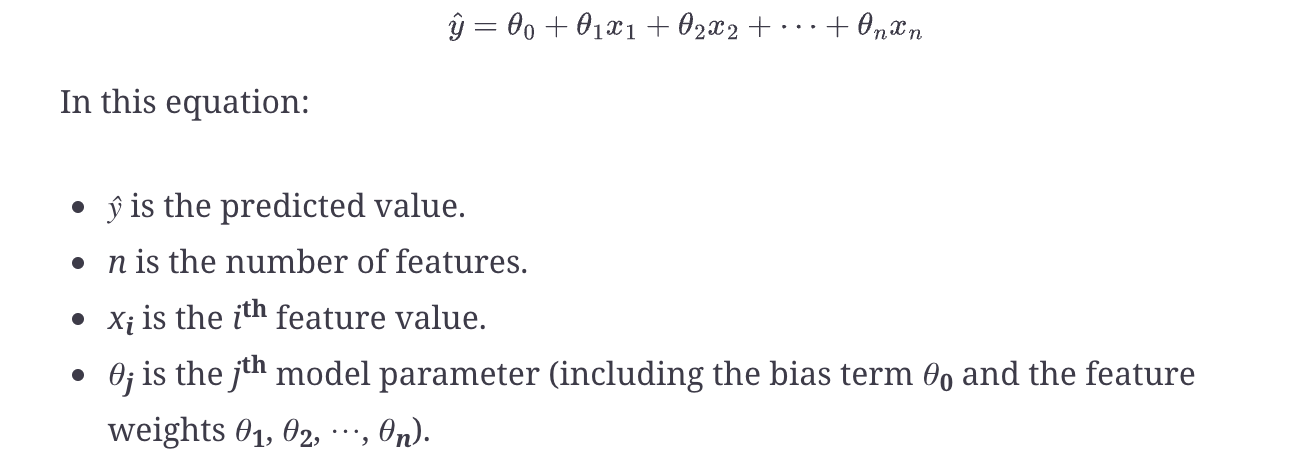

In a simpler(at least visually), vectorized form, it can be written as follows:
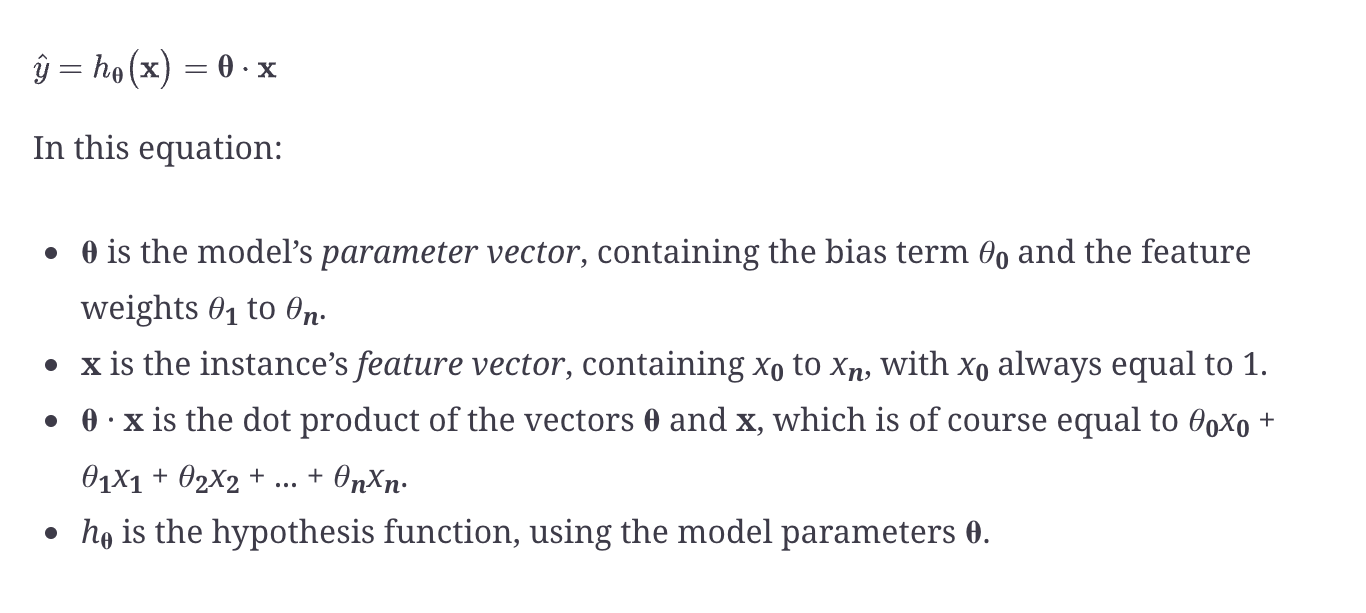

How to train your model?
Well, recall that training a model means setting its parameters so that the model best fits the training set. For this purpose, we first need a measure of how well (or poorly) the model fits the training data. 

To train a Linear Regression model, we need to find the value of θ that minimizes the RMSE. In practice, it is simpler to minimize the mean squared error (MSE) than the RMSE, and it leads to the same result (because the value that minimizes a function also minimizes its square root)

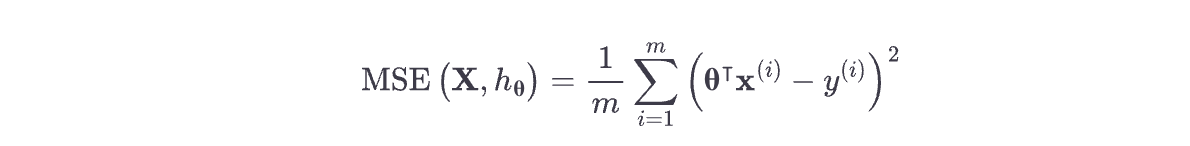

In [ ]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)


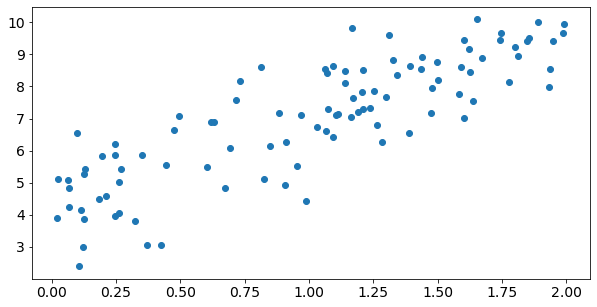

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(X, y, "o");

In [ ]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [ ]:
theta_best

array([[4.30114485],
       [2.68945996]])

We would have hoped for $θ_0$ = 4 and $θ_1$ = 3 instead of $θ_0$ = 4.215 and $θ_1$ = 2.770. Close enough, but the noise made it impossible to recover the exact parameters of the original function.

Now we can make predictions using 
𝛉
:

In [ ]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.30114485],
       [9.68006477]])

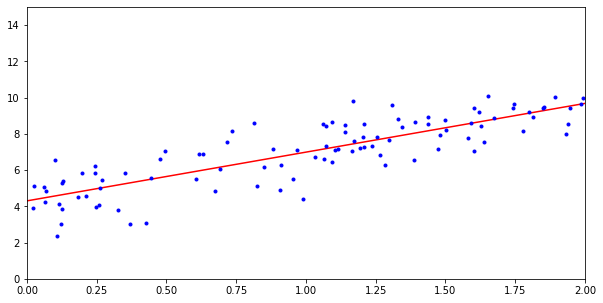

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

Performing Linear Regression using Scikit-Learn is simple:

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.30114485]), array([[2.68945996]]))

Now we will look at a very different way to train a Linear Regression model, which is better suited for cases where there are a large number of features or too many training instances to fit in memory.

###Gradient Descent
Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

It measures the local gradient of the error function with regard to the parameter vector θ, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!

Concretely, you start by filling θ with random values (this is called random initialization). Then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum.

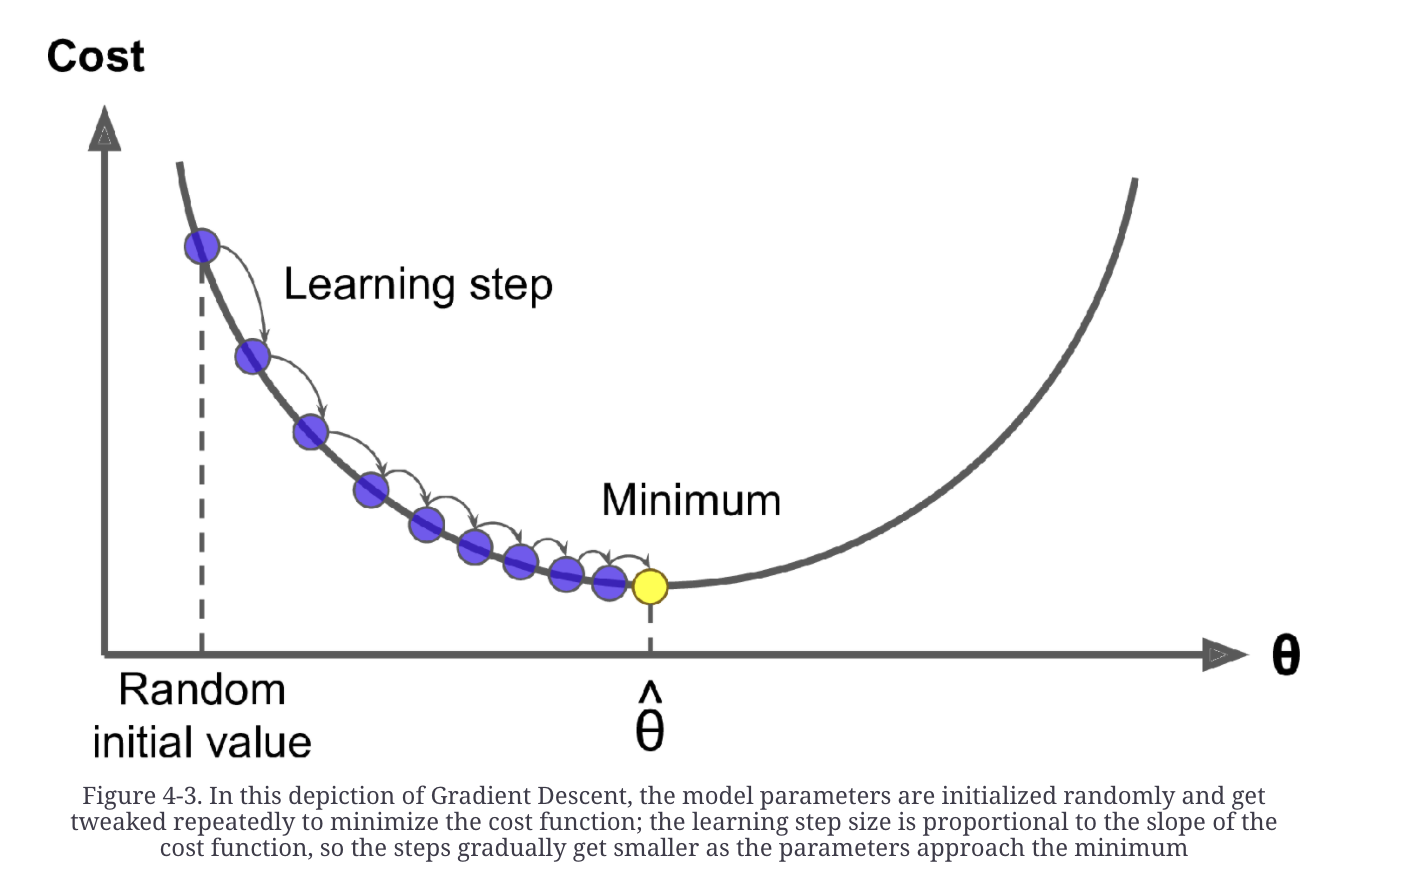

An important parameter in Gradient Descent is the size of the steps, determined by the learning rate hyperparameter. If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time. On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution 

Batch Gradient Descent:
To implement Gradient Descent, you need to compute the gradient of the cost function with regard to each model parameter θj. In other words, you need to calculate how much the cost function will change if you change θj just a little bit. This is called a partial derivative. 

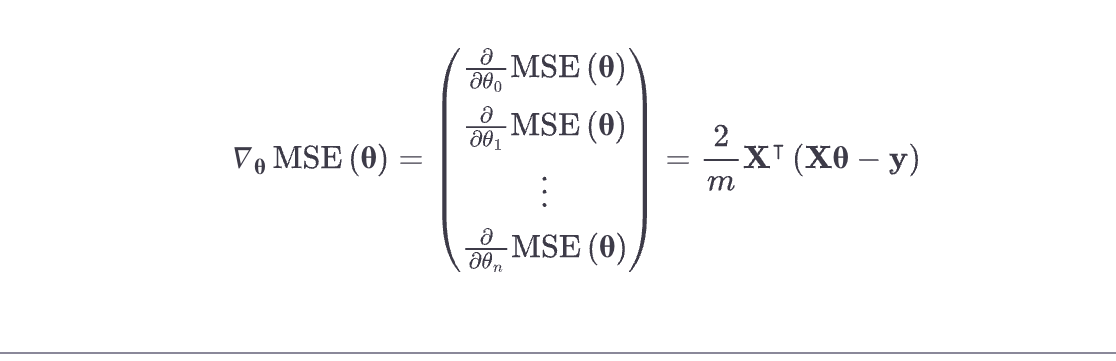

Once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill. This means subtracting ∇θMSE(θ) from θ. This is where the learning rate η comes into play:5 multiply the gradient vector by η to determine the size of the downhill step:

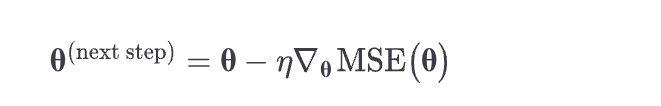

In [ ]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [ ]:
theta

array([[4.30114485],
       [2.68945996]])

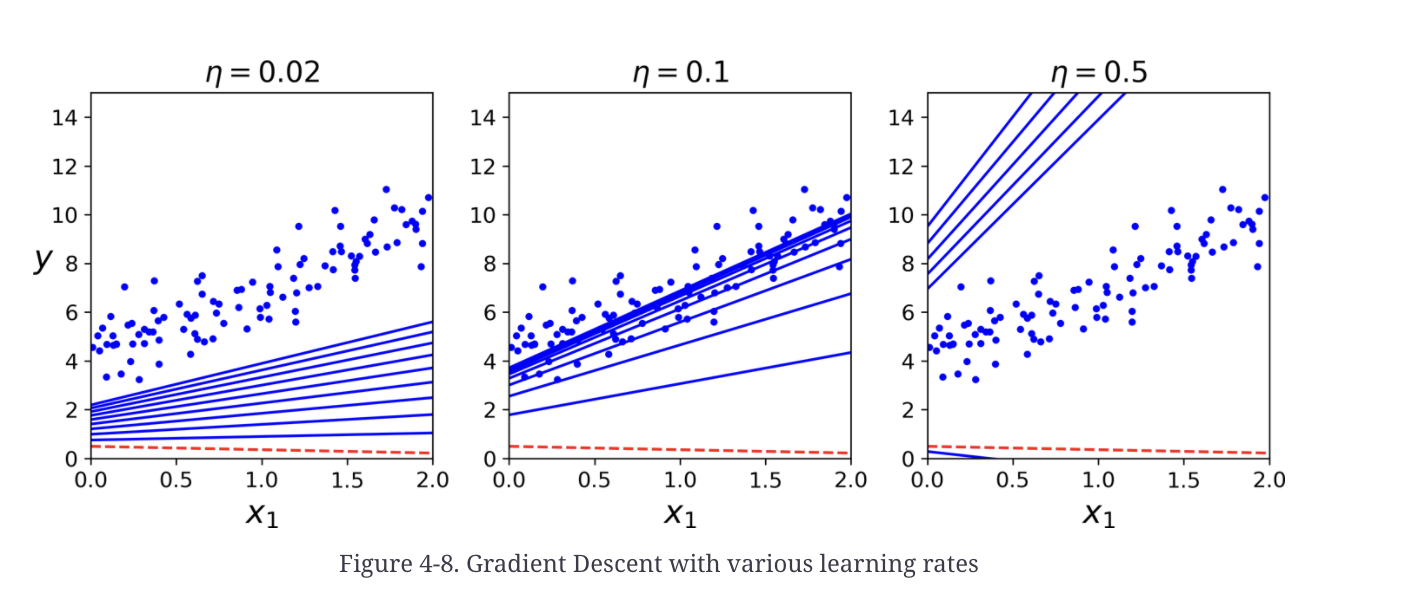

You may wonder how to set the number of iterations. If it is too low, you will still be far away from the optimal solution when the algorithm stops; but if it is too high, you will waste time while the model parameters do not change anymore. A simple solution is to set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny number ϵ (called the tolerance)—because this happens when Gradient Descent has (almost) reached the minimum.

##Stochastic Gradient Descent
* The main problem with Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, Stochastic Gradient Descent picks a random instance in the training set at every step and computes the gradients based only on that single instance.

* Obviously, working on a single instance at a time makes the algorithm much faster because it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration. 

* On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much less regular than Batch Gradient Descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down. So once the algorithm stops, the final parameter values are good, but not optimal.

* When the cost function is very irregular, this can actually help the algorithm jump out of local minima, so Stochastic Gradient Descent has a better chance of finding the global minimum than Batch Gradient Descent does.


This code implements Stochastic Gradient Descent using a simple learning schedule:



In [ ]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [ ]:
theta

array([[4.30710955],
       [2.68950985]])

To perform Linear Regression using Stochastic GD with Scikit-Learn, you can use the SGDRegressor class, which defaults to optimizing the squared error cost function. The following code runs for maximum 1,000 epochs or until the loss drops by less than 0.001 during one epoch (max_iter=1000, tol=1e-3). It starts with a learning rate of 0.1 (eta0=0.1), using the default learning schedule (different from the preceding one). 

In [ ]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.29161939]), array([2.68680893]))

##Logistic Regression

Logistic Regression (also called Logit Regression) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam?). If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), and otherwise it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). This makes it a binary classifier.

Just like a Linear Regression model, a Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the logistic of this result:

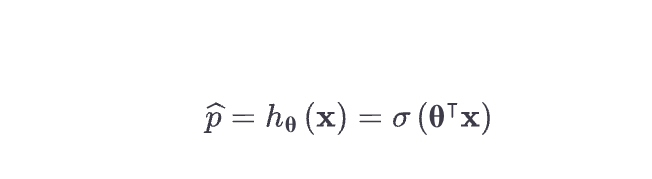



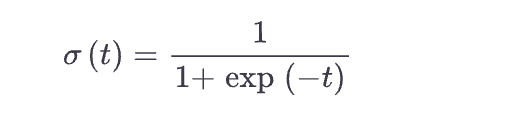


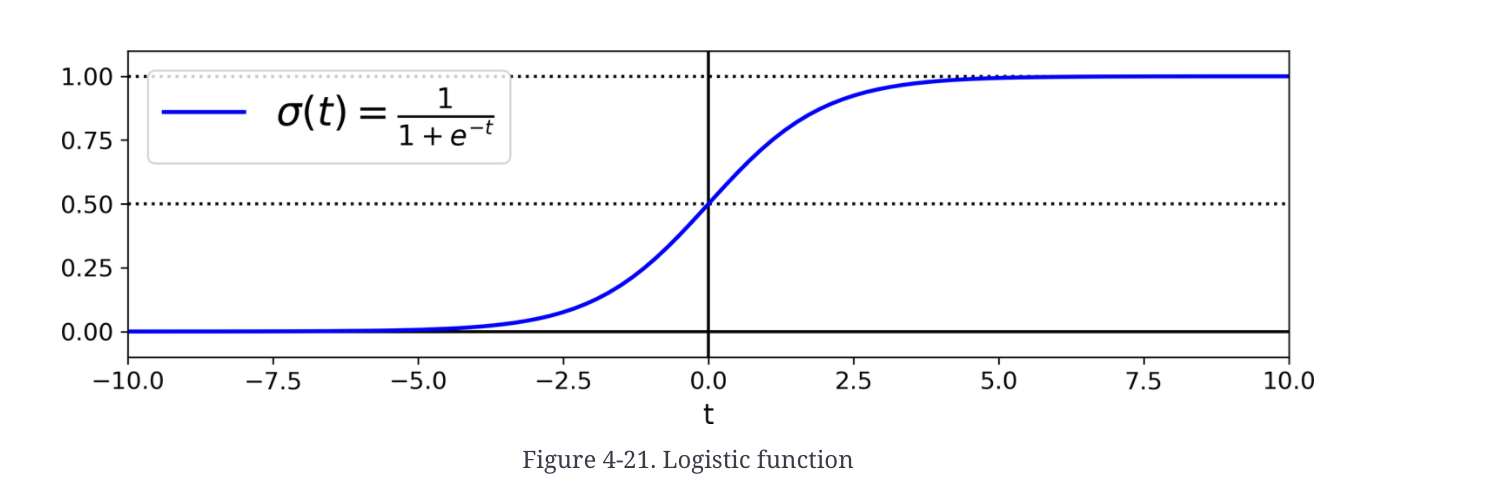


Logistic Regression Model Prediction

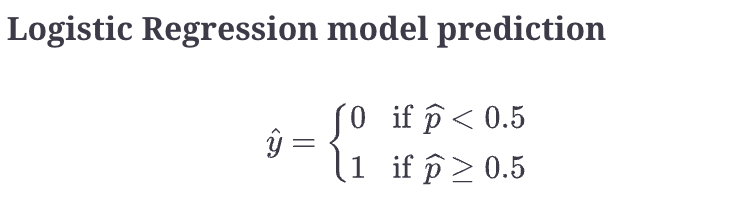

**Cost Function:**
Now you know how a Logistic Regression model estimates probabilities and makes predictions. But how is it trained? The objective of training is to set the parameter vector θ so that the model estimates high probabilities for positive instances (y = 1) and low probabilities for negative instances (y = 0). This idea is captured by the cost function shown in for a single training instance x.
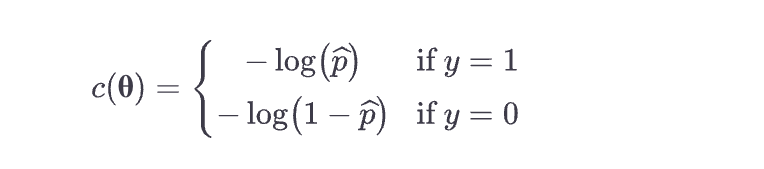


Let’s use the iris dataset to illustrate Logistic Regression. This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of three different species: Iris setosa, Iris versicolor, and Iris virginica:

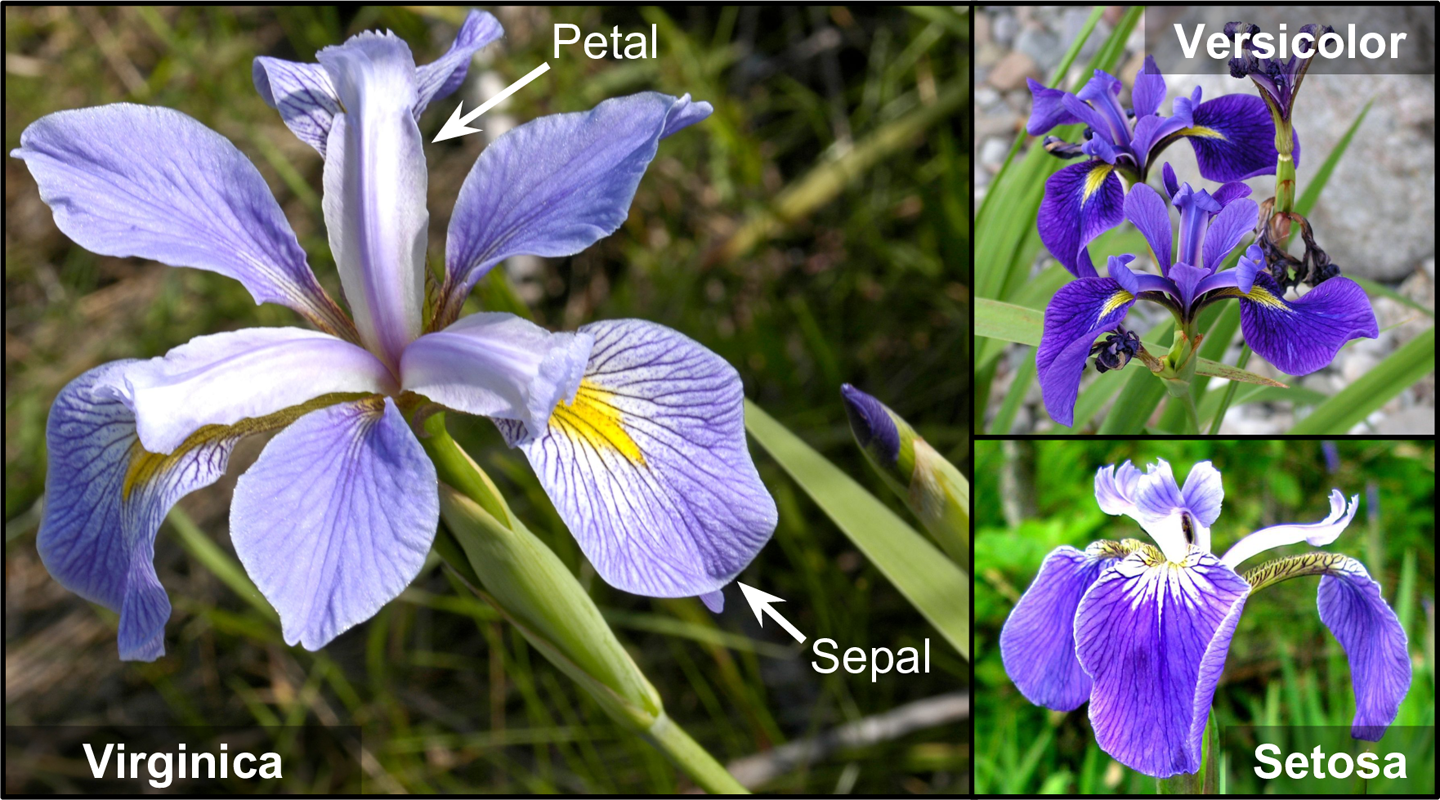

Let’s try to build a classifier to detect the Iris virginica type based only on the petal width feature. First let’s load the data:

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())


['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [ ]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let’s look at the model’s estimated probabilities for flowers with petal widths varying from 0 cm to 3 cm

/usr/local/lib/python3.7/dist-packages/matplotlib/patches.py:1327: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


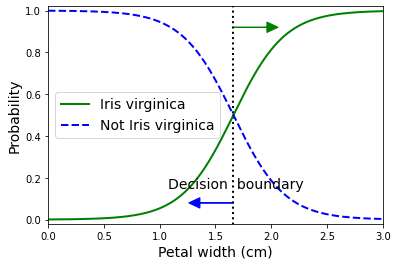

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

plt.show()

The petal width of Iris virginica flowers (represented by triangles) ranges from 1.4 cm to 2.5 cm, while the other iris flowers (represented by squares) generally have a smaller petal width, ranging from 0.1 cm to 1.8 cm. Notice that there is a bit of overlap. Above about 2 cm the classifier is highly confident that the flower is an Iris virginica (it outputs a high probability for that class), while below 1 cm it is highly confident that it is not an Iris virginica (high probability for the “Not Iris virginica” class). In between these extremes, the classifier is unsure. However, if you ask it to predict the class (using the predict() method rather than the predict_proba() method), it will return whichever class is the most likely. Therefore, there is a decision boundary at around 1.6 cm where both probabilities are equal to 50%: if the petal width is higher than 1.6 cm, the classifier will predict that the flower is an Iris virginica, and otherwise it will predict that it is not (even if it is not very confident):



In [ ]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])